In [1]:
pip install filterpy


SyntaxError: invalid syntax (3631472598.py, line 1)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
import numpy as np

# Load the CSV file
file_path = '/Users/arthu/OneDrive/Documents/Linear Accelerometer Trein 1.csv'  # Replace with your file path
data = pd.read_csv(file_path)

In [3]:
data

,Time (s),X (m/s^2),Y (m/s^2),Z (m/s^2)
0,0.012644,-0.224789,0.022504,-0.176961
1,0.022669,-0.232348,0.004359,0.008042
2,0.032695,-0.191629,0.000906,0.160814
3,0.042721,-0.083257,-0.010935,0.320832
4,0.052747,-0.020262,-0.057675,0.501325
...,...,...,...,...
59477,596.374137,0.147641,0.078721,0.576762
59478,596.384165,0.107232,0.094012,0.545484
59479,596.394193,0.114004,0.046345,0.460079
59480,596.404220,0.102882,-0.031117,0.254836


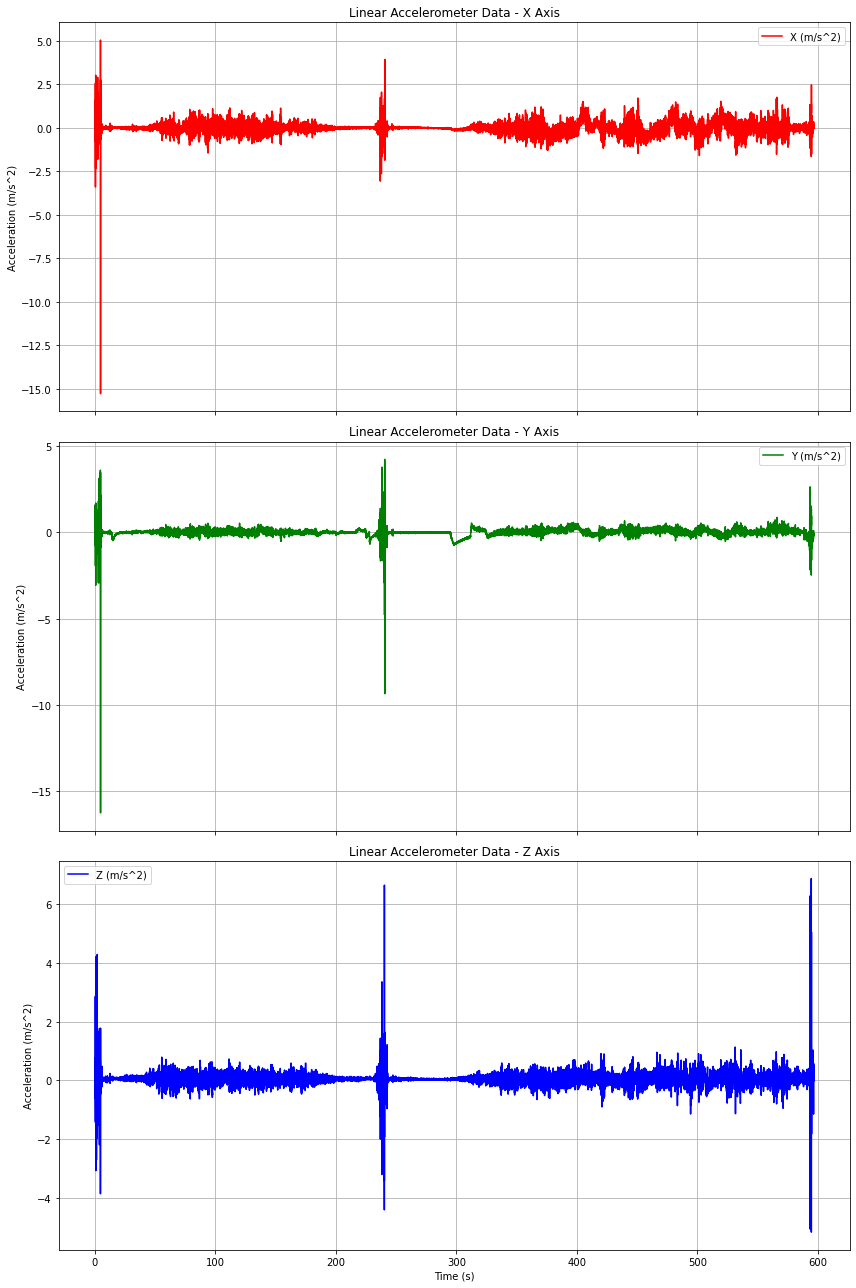

In [4]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Plot X-axis data
axs[0].plot(data['Time (s)'], data['X (m/s^2)'], label='X (m/s^2)', color='r')
axs[0].set_title('Linear Accelerometer Data - X Axis')
axs[0].set_ylabel('Acceleration (m/s^2)')
axs[0].legend()
axs[0].grid(True)

# Plot Y-axis data
axs[1].plot(data['Time (s)'], data['Y (m/s^2)'], label='Y (m/s^2)', color='g')
axs[1].set_title('Linear Accelerometer Data - Y Axis')
axs[1].set_ylabel('Acceleration (m/s^2)')
axs[1].legend()
axs[1].grid(True)

# Plot Z-axis data
axs[2].plot(data['Time (s)'], data['Z (m/s^2)'], label='Z (m/s^2)', color='b')
axs[2].set_title('Linear Accelerometer Data - Z Axis')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Acceleration (m/s^2)')
axs[2].legend()
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
# Define the time range to exclude
start_time = data['Time (s)'].iloc[0] + 15
end_time = data['Time (s)'].iloc[-1] - 15

# Filter the data to exclude the first and last 10 seconds
filtered_data = data[(data['Time (s)'] >= start_time) & (data['Time (s)'] <= end_time)]


In [6]:
# Function to apply Kalman filter
def apply_kalman_filter(data, process_var=1e-5, measurement_var=1e-1):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])  # initial state (location and velocity)
    kf.F = np.array([[1., 1.],
                     [0., 1.]])  # state transition matrix
    kf.H = np.array([[1., 0.]])  # measurement function
    kf.P *= 1000.  # covariance matrix
    kf.R = measurement_var  # measurement uncertainty
    kf.Q = np.array([[process_var, 0.],
                     [0., process_var]])  # process uncertainty

    filtered_data = []
    for measurement in data:
        kf.predict()
        kf.update(measurement)
        filtered_data.append(kf.x[0])
    return filtered_data

# Apply Kalman filter to each axis
filtered_data['X (m/s^2)'] = apply_kalman_filter(filtered_data['X (m/s^2)'])
filtered_data['Y (m/s^2)'] = apply_kalman_filter(filtered_data['Y (m/s^2)'])
filtered_data['Z (m/s^2)'] = apply_kalman_filter(filtered_data['Z (m/s^2)'])


<ipython-input-6-bee62483c3e9>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['X (m/s^2)'] = apply_kalman_filter(filtered_data['X (m/s^2)'])
<ipython-input-6-bee62483c3e9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Y (m/s^2)'] = apply_kalman_filter(filtered_data['Y (m/s^2)'])
<ipython-input-6-bee62483c3e9>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [7]:
# Define the window size in seconds
window_size = 5

# Calculate the number of windows
start_time = filtered_data['Time (s)'].iloc[0]
end_time = filtered_data['Time (s)'].iloc[-1]
num_windows = int((end_time - start_time) // window_size)

# Initialize lists to store the results
window_means = []
window_stds = []
window_times = []

# Loop over each window and calculate the statistics
for i in range(num_windows):
    window_start = start_time + i * window_size
    window_end = window_start + window_size
    window_data = filtered_data[(filtered_data['Time (s)'] >= window_start) & (filtered_data['Time (s)'] < window_end)]
    
    if not window_data.empty:
        window_mean = window_data[['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)']].mean()
        window_std = window_data[['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)']].std()
        
        window_means.append(window_mean)
        window_stds.append(window_std)
        window_times.append(window_start + window_size / 2)  # Middle of the window

# Create DataFrames for means and standard deviations
window_means_df = pd.DataFrame(window_means)
window_means_df['Time (s)'] = window_times

window_stds_df = pd.DataFrame(window_stds)
window_stds_df['Time (s)'] = window_times

# Display the resulting DataFrames
print("Window Means:")
print(window_means_df)

print("\nWindow Standard Deviations:")
print(window_stds_df)

Window Means:
     X (m/s^2)  Y (m/s^2)  Z (m/s^2)    Time (s)
0    -0.000455  -0.156383   0.061268   17.521152
1    -0.008305  -0.015005   0.060188   22.521152
2    -0.013305  -0.004614   0.061155   27.521152
3    -0.027527   0.022913   0.064818   32.521152
4    -0.026074   0.040243   0.059261   37.521152
..         ...        ...        ...         ...
108  -0.010358   0.087474   0.041013  557.521152
109  -0.021600   0.228610   0.039520  562.521152
110  -0.025534   0.208776   0.028400  567.521152
111   0.073623   0.194877   0.065326  572.521152
112  -0.035528   0.100159   0.057168  577.521152

[113 rows x 4 columns]

Window Standard Deviations:
     X (m/s^2)  Y (m/s^2)  Z (m/s^2)    Time (s)
0     0.009392   0.117759   0.006272   17.521152
1     0.012927   0.009982   0.012861   22.521152
2     0.027194   0.012561   0.022792   27.521152
3     0.063204   0.026599   0.028315   32.521152
4     0.030904   0.033886   0.031679   37.521152
..         ...        ...        ...         ...
10

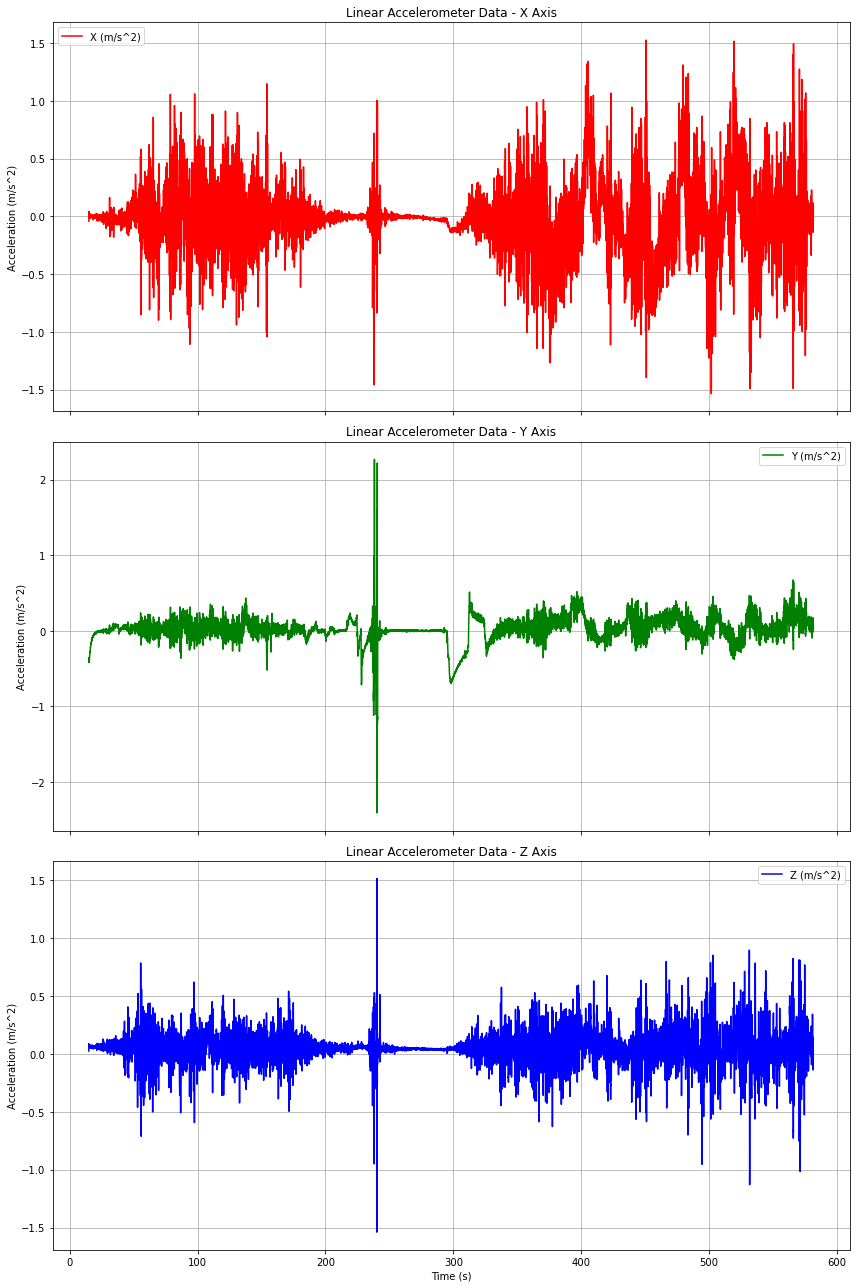

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Plot X-axis data
axs[0].plot(filtered_data['Time (s)'], filtered_data['X (m/s^2)'], label='X (m/s^2)', color='r')
axs[0].set_title('Linear Accelerometer Data - X Axis')
axs[0].set_ylabel('Acceleration (m/s^2)')
axs[0].legend()
axs[0].grid(True)

# Plot Y-axis data
axs[1].plot(filtered_data['Time (s)'], filtered_data['Y (m/s^2)'], label='Y (m/s^2)', color='g')
axs[1].set_title('Linear Accelerometer Data - Y Axis')
axs[1].set_ylabel('Acceleration (m/s^2)')
axs[1].legend()
axs[1].grid(True)

# Plot Z-axis data
axs[2].plot(filtered_data['Time (s)'], filtered_data['Z (m/s^2)'], label='Z (m/s^2)', color='b')
axs[2].set_title('Linear Accelerometer Data - Z Axis')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Acceleration (m/s^2)')
axs[2].legend()
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()